In [1]:
import pandas as pd
import numpy as np
#coding=utf-8
import numpy as np
import pandas as pd
from scipy.stats import mode
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from matplotlib import  pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn import preprocessing  
min_max_scaler = preprocessing.MinMaxScaler()  
from sklearn.model_selection import KFold,StratifiedKFold


In [2]:
train = pd.read_csv("../input/train_order_info.csv")
test = pd.read_csv("../input/test_order_info.csv")
fulldata = pd.concat([train,test],axis = 0,ignore_index = True)
train.head(),train.shape,test.shape

(   amt_order type_pay           time_order sts_order        phone  unit_price  \
 0       39.0     在线支付  2017-04-15 09:21:18      等待收货  159****2937         NaN   
 1       39.0     在线支付  2017-04-15 09:21:18        完成  159****2937         NaN   
 2      288.0     在线支付  2016-10-24 08:57:06       NaN  137****8223         NaN   
 3      428.0     在线支付  2016-10-27 20:04:48        完成  137****8223         NaN   
 4      428.0     在线支付  2016-10-27 20:04:48       NaN  137****8223         NaN   
 
                    id                      no_order_md5  \
 0  609460154345197832  ae3b7fd144ff7ee8658d92137a924836   
 1  609460154345197832  ae3b7fd144ff7ee8658d92137a924836   
 2  609460154345197832  1d7b1294cdbfe24815e39c458cd059d1   
 3  609460154345197832  51ee194476e14e9976db834c08f20e21   
 4  609460154345197832  51ee194476e14e9976db834c08f20e21   
 
                        name_rec_md5 product_id_md5  
 0  afeb593025b37afbe8179c456b8855f1            NaN  
 1  afeb593025b37afbe8179c456b8855f1

In [ ]:
len(fulldata.id.unique())

In [35]:
'''
Index(['amt_order', 'type_pay', 'time_order', 'sts_order', 'phone',
       'unit_price', 'id', 'no_order_md5', 'name_rec_md5', 'product_id_md5'],
      dtype='object')
'''

mm = fulldata.ix[fulldata.type_pay == "货到付款"]
len(mm.id.unique())   #有  5449 条ID属于中间状态


d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


25731

In [4]:
#fulldata['amt_order']   去除极值 ,  缺失值填充
fulldata['amt_order'].fillna(fulldata['amt_order'].median(),inplace = True)
fulldata['amt_order'].value_counts().sort_values(ascending = False)
ulimit = np.percentile(fulldata['amt_order'],99)
fulldata['amt_order'].loc[fulldata['amt_order']>ulimit] = ulimit
fulldata['amt_order'] = fulldata['amt_order'].apply(lambda x: abs(x))   
np.min(fulldata['amt_order']),np.max(fulldata['amt_order'])

d:\gongju\python3.6 64\anzhuang\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(0.0, 5788.0)

In [6]:
fulldata.type_pay.value_counts().sort_values(ascending = False)

在线支付          2451964
货到付款           297918
在线             134974
混合支付            19506
分期付款             6733
在线+京豆            3247
上门自提             1861
在线+限品东券           892
余额                727
京豆                689
邮局汇款              669
在线+东券支付           580
公司转账              565
京豆混合支付            516
前台自付              496
京豆支付              424
在线+定向东券           254
在线+全品东券           177
定向东券              162
在线+东券             143
白条支付              104
东券混合支付             78
在线预付               57
京豆东券混合支付           48
在线支付               38
定向京券支付             36
积分支付               18
定向京券               18
在线+余额              16
京券混合支付              9
限品京券                6
余额+限品东券             5
在线+京券支付             5
全品京券                3
在线+全品京券             2
在线+余额+限品东券          1
在线+限品京券             1
分期付款(招行)            1
高校代理-自己支付           1
京券全额支付              1
京豆京券混合支付            1
高校代理-代理支付           1
京券支付                1
Name: type_pay, dtype: int64

In [10]:
def mygroup00(group):
    return group
fulldata.ix[fulldata.type_pay == "分期付款"].groupby(by = 'id').apply(mygroup00)


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5
1400,1499.0,分期付款,1433398975,已取消,186****8020,NaN,574819157879558408,b81910899510f99af6efd694ccf0f580,4d56f9061d178dadb06a3a2c4a5dbeb7,NaN
1419,5187.8,分期付款,1424947963,已取消,186****8020,NaN,574819157879558408,e218732777f5feb8ed8dfcb5d5f6b2f1,4d56f9061d178dadb06a3a2c4a5dbeb7,NaN
2498,6488.0,分期付款,2015-05-27 07:53:13,完成,136****4781,6488.0,462153270895317256,241e240b3b94660b1b07933d1bb51e5a,895809b560a08db45b8c59034f8180fe,c8d999ce6869c8c3df467da2174f02bf
2585,4888.0,分期付款,2016-03-18 21:44:16,NaN,138****1538,NaN,614543041637650696,d6cc869c13211f45e88550c1862a8851,402cca71c5c116be9364db824c5f0e23,NaN
2629,3199.0,分期付款,2015-08-28 19:43:51,完成,135****9284,3199.0,20160816010006090837,fcabb0ed463c026b2f1683333ccddeda,3798cad9de4816b20d371c58822e3c0e,a1f770ae5de9c6fe830a83a1d5eadbaf
2951,5288.0,分期付款,1445413794,已取消,155****6970,NaN,20160726150005324994,c708ac51802fa816cf0290f4e8aa3f4f,76a314b7f263d1c384466cb6fe889865,NaN
3909,5688.0,分期付款,1455232914,已取消,187****2621,NaN,20160504230002751981,5a63250a992213848eeb52fc659258de,ab14bdd0fdab54c5a60c2580f238811f,NaN
4964,1799.0,分期付款,1401296237,已取消,150****9612,NaN,556164638325084424,efca2f60b6b90db268d04e2c92c929fb,0a76e28d360b99abcf729dc01e46fdd6,NaN
4969,1699.0,分期付款,1400784709,已取消,150****9612,NaN,556164638325084424,832da10e35022f701d8b6dc8347e9eac,0a76e28d360b99abcf729dc01e46fdd6,NaN
4978,4799.0,分期付款,1389187175,已取消,136****3234,NaN,556164638325084424,c7cfaa5516919824adf5fd80366504d9,0a76e28d360b99abcf729dc01e46fdd6,NaN


In [11]:
def mygroup00(group):
    return group
fulldata.ix[fulldata.type_pay == "白条支付"].groupby(by = 'id').apply(mygroup00)

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5
1395,3699.0,白条支付,1403111003,已取消,186****8020,NaN,574819157879558408,3f792af5c303842d0253879c92b09756,4d56f9061d178dadb06a3a2c4a5dbeb7,NaN
1398,4899.0,白条支付,1403622749,已取消,186****8020,NaN,574819157879558408,bfcd9926ac86c93016b68cd2505e44e6,4d56f9061d178dadb06a3a2c4a5dbeb7,NaN
1416,3699.0,白条支付,1402931283,已取消,186****8020,NaN,574819157879558408,0a6f872b9bb23494a61fcecc7e795335,4d56f9061d178dadb06a3a2c4a5dbeb7,NaN
6072,99.0,白条支付,2016-10-25 19:34:08,完成,188****5161,NaN,614948482263814152,064df1f2bbd45cce37d7db4cb1891bef,bff1b9d71a245e397ce1c6a66c09e499,NaN
113057,4999.0,白条支付,1404467379,已取消,159****5603,NaN,614222361243160584,cb7c68ef6b5160fbe647ae2fabb986fa,ac68205240a25d0cee729cf098eb4ed9,NaN
113095,4999.0,白条支付,1404467352,已取消,159****5603,NaN,614222361243160584,c1c44adb491d234c95fdfe55291e1e2a,ac68205240a25d0cee729cf098eb4ed9,NaN
144335,198.0,白条支付,2016-11-02 15:28:12,NaN,186****0488,NaN,575967718906269960,eeac5ddfc3311a70788fe00ea95e6994,e5cbf689eb3464f5cfc160e61260f5b7,NaN
150957,14.9,白条支付,1457842476,已取消,187****7777,14.9,20160403190001918808,5f2393b92563d568ed7b9eb10476d8b7,081eb13d58f71caba7502d465b6c5e39,aab4de3ac29ee406b57034052cde1f58
165483,19999.0,白条支付,2014-07-23 23:54:13,已取消,138****5558,NaN,548470024143114504,9234a4f8c5d308980053690700e55429,a575ff5d923e9e543c79b086d3f0690c,NaN
222061,65.0,白条支付,2016-04-01 16:11:12,完成,138****3707,NaN,523764552211369992,97ce8d812db72418e83c0a6bfc50e47a,8aae66866e67e1e13ae390108d04a60c,NaN


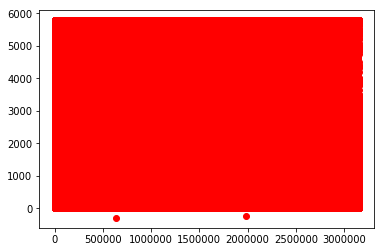

In [35]:
plt.scatter(np.arange(fulldata.shape[0]),fulldata['amt_order'],c = 'r',marker = 'o') 
plt.show()

In [5]:
#还没统计，不能归一化
# from sklearn import preprocessing  
# min_max_scaler = preprocessing.StandardScaler()
# fulldata['amt_order'] = min_max_scaler.fit_transform(fulldata['amt_order'].reshape(-1, 1))
fulldata.isnull().sum()/fulldata.shape[0]

amt_order         0.000000
type_pay          0.072888
time_order        0.025304
sts_order         0.123957
phone             0.055974
unit_price        0.735037
id                0.000000
no_order_md5      0.025304
name_rec_md5      0.080888
product_id_md5    0.735046
dtype: float64

In [ ]:
# 先按照分组将缺失值填充后，在整体上填充   不行，因为有的全是  空缺值，所以没法
fulldata["lossNUm"] = fulldata.isnull().sum(axis = 1)
#先把状态填充，找出有多少状态取消，多少状态
fulldata["sts_order"].fillna(fulldata["sts_order"].value_counts().sort_values(ascending = False).index[0],inplace = True)

fulldata["sts_order"].value_counts()  #先一一转化，然后统计每个人的总购买力（不含取消值），总取消值多少
#  先对时间进行处理
# fulldata.ix[fulldata.time_order == "0"]

In [ ]:
mm = fulldata.ix[fulldata["sts_order"] == "未入住"]

In [17]:
fulldata.ix[fulldata["sts_order"] == "未入住"]
# 这个只有未入住，也没有前序步骤和后续步骤
# mm = fulldata.ix[fulldata["id"] == '20160421100002337461']
# mm.ix[mm.no_order_md5 == '563570ac38f7003ad40e8d8291eb86da']
#挑了几个，仍然只有未入住这条信息，到底退款没有   
mm = fulldata.ix[fulldata["id"] == '586958376831815688']  #11
mm.ix[mm.no_order_md5 == '24eac7c1d95a8f6f4abec440ddaa386a']
#还是当成成功消费吧   就当成 成功消费吧，原则上是不能退房费的。

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
1781451,798.0,前台自付,2017-02-24 16:17:21,未入住,NaN,NaN,586958376831815688,24eac7c1d95a8f6f4abec440ddaa386a,f446b7a9916281c53a302b42f662c86b,NaN,3


In [11]:
fulldata.ix[fulldata["sts_order"] == "等待收货"].head() 
# mm = fulldata.ix[fulldata["id"] == '609460154345197832']
# mm.ix[mm.no_order_md5 == 'ae3b7fd144ff7ee8658d92137a924836']
#这个订单又是 有收获，有完成


mm = fulldata.ix[fulldata["id"] == '587575870923739144']
mm.ix[mm.no_order_md5 == '4b098cdfd1e0fe2d34f33b2d3840cdca']
# 这个订单 等待收货，但是没有后续 的操作，也没有前序步骤


d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
47,84.0,货到付款,2016-04-23 10:39:56,等待收货,159****8718,NaN,587575870923739144,4b098cdfd1e0fe2d34f33b2d3840cdca,0bf08f99bd97a2ee522d94bbede23125,NaN,2


In [7]:
fulldata.ix[fulldata["sts_order"] == "出票成功"].head() 

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
2784,24.0,在线支付,2016-07-04 12:43:15,出票成功,NaN,NaN,562364877608325128,220789c061026f244a1955dfaad7e419,86fe791ebe66f4bef5792cf694a8a38d,NaN,3
2811,453.5,在线支付,2016-07-04 10:58:40,出票成功,NaN,NaN,562364877608325128,8ee3e28caa62a876c58d83789d510931,86fe791ebe66f4bef5792cf694a8a38d,NaN,3
7012,69.5,在线支付,2017-01-18 17:25:39,出票成功,NaN,NaN,607951709636923400,a90e7be124c863b69f07b336394c8292,b923752bbd8067bc7d5e21392261dca4,NaN,3
7038,119.5,在线支付,2017-02-01 18:22:11,出票成功,NaN,NaN,607951709636923400,82018dc520f105ab933cb4be773f6dca,b923752bbd8067bc7d5e21392261dca4,NaN,3
7060,213.5,在线支付,2017-01-18 17:12:35,出票成功,NaN,NaN,607951709636923400,5826810eff65558837cf13d49b7709fb,b923752bbd8067bc7d5e21392261dca4,NaN,3


In [71]:
fulldata.ix[fulldata["sts_order"] == "未抢中"].head()   #虽然是未抢中，但是仍然花钱了，化为成功消费

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
1009,1.0,在线,2017-01-01 14:03:39,未抢中,135****5092,NaN,589172643916157192,bf28ff2e89997bb1d6dead1f06226b98,3f0e763b0cc2dfb78c2bf3d26c1c5d96,NaN,2
1042,1.0,在线,2016-08-12 00:46:46,未抢中,135****5092,NaN,589172643916157192,b66a9282d305a9191306450e35e7fa7a,3f0e763b0cc2dfb78c2bf3d26c1c5d96,NaN,2
1088,10.0,在线,2016-10-03 13:57:58,未抢中,180****4626,NaN,592035723775840520,3a3f99d316766159df5aa3cd5c5e654c,557d99cce45fc5a732eeba90b6609cde,NaN,2
1096,5.0,在线,2016-10-03 13:56:16,未抢中,180****4626,NaN,592035723775840520,67ade93156a4e9788544b6f523fc436a,557d99cce45fc5a732eeba90b6609cde,NaN,2
1100,10.0,在线,2016-10-03 14:00:07,未抢中,180****4626,NaN,592035723775840520,7c8bf742825d02dd7b04ce43c2fc5551,557d99cce45fc5a732eeba90b6609cde,NaN,2


In [72]:
fulldata.ix[fulldata["sts_order"] == "已取消"].head()   

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
15,99.98,在线支付,2016-08-18 07:10:02,已取消,186****8621,NaN,20160821230006305142,38797d642f45d267735a5f4295004188,894e84419009958543c4b85f8ca47c25,NaN,2
16,99.98,在线支付,2016-08-21 22:36:35,已取消,186****8621,NaN,20160821230006305142,fe219d351416ae8d86f2894f6c433f98,894e84419009958543c4b85f8ca47c25,NaN,2
84,44.00,在线支付,2014-12-02 01:15:10,已取消,185****5456,39.0,20160506110002792558,4de2cd3a7ca1dcf7f371f38c4ce89eb7,26c6d250f8e2389fe674a7cc2fd8bbd6,a4291b2d7f71938d2dab737bc89f3f11,0
102,893.00,在线支付,2016-02-18 14:17:34,已取消,185****5456,0.0,20160506110002792558,e9402229ae82a7d8dade4ad082cd0038,26c6d250f8e2389fe674a7cc2fd8bbd6,04716d6249cb5cb3e303e8861f77f106,0
103,893.00,在线支付,2016-02-18 14:17:34,已取消,185****5456,689.0,20160506110002792558,e9402229ae82a7d8dade4ad082cd0038,26c6d250f8e2389fe674a7cc2fd8bbd6,4043ab6c5c50fb0e4c9d9112683c3bee,0


In [6]:
fulldata.describe()

,amt_order,unit_price
count,3.056580e+06,8.353610e+05
mean,6.624305e+02,2.817265e+02
std,1.420897e+05,1.226974e+04
min,-2.980000e+02,0.000000e+00
25%,4.400000e+01,1.580000e+01
50%,9.900000e+01,4.950000e+01
75%,2.085000e+02,1.090000e+02
max,1.988889e+08,5.460000e+06


In [23]:
fulldata.ix[fulldata["sts_order"] == "已晒单"].head()
# mm = fulldata.ix[fulldata["id"] == '609219516647346184']  过期关闭
# mm.ix[mm.no_order_md5 == '332649b99c7c44024569ee72c2b180a3']  #只有晒单，没有完成这些步骤
mm = fulldata.ix[fulldata["id"] == '583397408457625864']
mm.ix[mm.no_order_md5 == 'f21a1107df2e6a71d108db70bff65bb5']   #故全部视为 成功完成

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
97583,10.0,在线,2017-03-09 15:45:28,已晒单,135****0232,NaN,583397408457625864,f21a1107df2e6a71d108db70bff65bb5,e5f2c440ec217348227376ed63fdf113,NaN,2


In [31]:
fulldata.ix[fulldata["sts_order"] == "过期关闭"].head()
# mm = fulldata.ix[fulldata["id"] == '586914766983794952']  #过期关闭
# mm.ix[mm.no_order_md5 == '00dec6892db3b9d594bdf1efa5d7bb95']  #只有过期关闭，没有完成这些步骤

# mm = fulldata.ix[fulldata["id"] == '618172287853531400']  #过期关闭
# mm.ix[mm.no_order_md5 == '9bae03afb032000743d8260cea9fbe94']  #只有过期关闭，没有完成这些步骤

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
1962101,10.0,在线支付,2017-03-01 00:51:29,过期关闭,NaN,NaN,586914766983794952,00dec6892db3b9d594bdf1efa5d7bb95,8108e9d6c12b265711d89ae2fc188a1c,NaN,3
2212389,1.0,在线支付,2017-04-27 01:25:35,过期关闭,NaN,NaN,615286154312290568,a557546ad3e565760812fa9935f39a9a,05e7c8fa9c149831bdea6c917b31b4dd,NaN,3
2439076,1.0,在线支付,2017-04-25 00:21:51,过期关闭,NaN,NaN,636684087750299912,3bdd90b7ed6a538005593b6faf258911,1089d685f53171e1a5d430b1d4e9be30,NaN,3
2444102,500.0,在线支付,2017-05-04 11:10:22,过期关闭,NaN,NaN,632658928555003912,0a0ca855e9d6833bc8895ed15c5f8dc3,caf3b42943ab71b85acf6dde7586e42f,NaN,3
2467880,1.0,在线支付,2017-05-02 21:43:43,过期关闭,NaN,NaN,618172287853531400,9bae03afb032000743d8260cea9fbe94,7e090f620a3b027e12d9063eb555759f,NaN,3


In [74]:
fulldata.ix[fulldata["sts_order"] == "正在出库"].head()

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
3306,66.0,在线支付,2017-03-06 01:00:25,正在出库,188****1777,NaN,576477602240270600,1477c1c2d7253ba6038fcfd1f4e13571,da57206d583ec308a3cbce3ed0cd92bf,NaN,2
8046,89.0,在线支付,2017-01-23 12:19:47,正在出库,185****2176,NaN,575154840410263816,db772d413964b595064fc792ffc96a38,e3d673db836d232558ed5007f1a8ad3f,NaN,2
8720,2598.0,在线支付,2017-04-11 17:37:08,正在出库,150****1552,NaN,602880726743912712,76b8dc268cb6c0c9d3e1873e7f1ceb87,3669be68b030701a7fce244ca2b22130,NaN,2
14646,210.8,在线支付,2017-03-08 05:53:24,正在出库,186****7723,NaN,607228731005604104,6c72868a25ee1771f7ae0f9d29b98e06,0b128c6bdd092927689385c9d0348287,NaN,2
16727,69.0,在线支付,2017-01-23 13:48:20,正在出库,138****7432,NaN,575202666171339016,3f997ac94bc9d61c4aeead3317121829,5e736f80a457451586f27d27c34019de,NaN,2


In [4]:
fulldata.ix[fulldata["sts_order"] == "过期放弃"].head() 

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5
405403,25.0,在线,2016-08-20 12:40:12,过期放弃,134****1923,NaN,578720819853660424,f311be30b48dbacf8fcad6e8eaae7e71,c51ec461c0e45601a2098908dec54058,NaN
2628311,1.0,在线,2016-12-18 08:44:57,过期放弃,155****0778,NaN,619357942835056648,ba51815401fc5da56834b00330551832,18e58415c03ec94921c9e5030d1d9f72,NaN
3025755,31.0,在线,2016-04-29 22:46:33,过期放弃,180****6212,NaN,636024246631403784,7d7bde930e6b82e5aa0740eee51d3917,8bee7cccb1444453edc4b57ffa894aa2,NaN


In [86]:
mm = fulldata.ix[fulldata["id"] == '576477602240270600']
mm.ix[mm.no_order_md5 == '1477c1c2d7253ba6038fcfd1f4e13571']

#为什么一个订单号出库，相同的订单号就查不到？
'''
难道是下单出库等一个类别即使是同一时间下单，也会列举每个类别的金额（总金额，时间等），但是共用一个订单号
但是为什么有的订单只有上门自提，没有其他的前期数据？难道是掉了？还是合并了？

'''

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
3306,66.0,在线支付,2017-03-06 01:00:25,正在出库,188****1777,NaN,576477602240270600,1477c1c2d7253ba6038fcfd1f4e13571,da57206d583ec308a3cbce3ed0cd92bf,NaN,2


In [87]:
#以id为单位进行填充
def mygroup(group):
    print(".....................")
    return group
tmp1 = fulldata.iloc[0:3000,:].groupby(by=['id','no_order_md5']).apply(mygroup)
tmp1

.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
..........

.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
..........

.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
..........

.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
..........

.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
.....................
..........

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm
0,39.00,在线支付,2017-04-15 09:21:18,等待收货,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,2.0
1,39.00,在线支付,2017-04-15 09:21:18,完成,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,2.0
2,288.00,在线支付,2016-10-24 08:57:06,完成,137****8223,NaN,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,NaN,3.0
3,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,2.0
4,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,3.0
5,88.00,货到付款,2016-02-20 12:09:50,完成,137****8223,NaN,609460154345197832,7b14b3d3f23a46050cf6832c37354f84,eac9416f834d481d7c88da6134468d03,NaN,2.0
6,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,NaN,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,NaN,2.0
7,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,NaN,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,NaN,3.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,16.80,在线支付,2016-12-07 02:57:57,完成,152****3139,NaN,521501199715799048,ec7fb7e582a2099e0c2e22d6f85f93a0,ccbc99481f4ad7795fb19cb0039831b7,NaN,2.0


In [ ]:
fulldata.ix[fulldata["no_order_md5"] == 'e292a25a07fd6a163b621018680ba6e4']

# 下面开始真正的处理数据

In [2]:
#购物有京东，线下购物，彩票 等，如何细分呢   ？
#今天的分类是错的，要按照京东的分类进行重新分类
#看自己的京东账单一一 细分各种分类
'''
完成               2147487已取消               367100
充值成功              338095未抢中               120283
已完成                64176订单取消               60717
等待收货               21889充值失败;退款成功           8164
出票成功                6985退款完成                3950
等待付款                2453已收货                 1926
充值失败                1554正在出库                1171
出票失败                1106退款成功                 935
商品出库                 917已晒单                  793
抢票已取消                689正在处理                 564
等待审核                 282付款成功                 215
预订结束                 194购买成功                 187
失败退款                 179请上门自提                 86
订单已取消                 74等待处理                  67
配送退货                  66已退款                   64
预约完成                  49等待退款                  44
缴费成功                  44等待付款确认                34
未入住                   30下单失败                  30
已取消订单                 27已确认                   23
过期关闭                  23正在送货（暂不能上门自提）         17
已入住                   11充值失败;退款处理中             9
正在充值                   9商品退库                   5
等待分期付款                 4支付失败                   4
部分充值成功;退款成功            3过期放弃                   3
等待揭晓                   2等待厂商处理                 2
预订中                    1等待发码                   1
发货中                    1  退款中                    1
Name: sts_order, dtype: int64


在线支付          2451964货到付款           297918在线             134974
混合支付            19506分期付款             6733在线+京豆            3247
上门自提             1861在线+限品东券           892余额                727
京豆                689邮局汇款              669在线+东券支付           580
公司转账              565京豆混合支付            516前台自付              496
京豆支付              424在线+定向东券           254在线+全品东券           177
定向东券              162在线+东券             143白条支付              104
东券混合支付             78在线预付               57京豆东券混合支付           48
在线支付               38定向京券支付             36积分支付               18
定向京券               18在线+余额              16京券混合支付              9
限品京券                6余额+限品东券             5在线+京券支付             5
全品京券                3在线+全品京券             2在线+余额+限品东券          1
在线+限品京券             1分期付款(招行)            1高校代理-自己支付           1
京券全额支付              1京豆京券混合支付            1高校代理-代理支付           1
京券支付                1
Name: type_pay, dtype: int64

处理前：1.中间状态全部转换为最终状态；2.一个订单号的条目（已完成全部合并为一个数目）

统计有几种支付方式，常见的支付方式是什么，（混合、东券、京劵、京豆、余额（这一个条目代表网上购物活跃度））多少次，
白条、分期 有多少次

订单状态+支付方式  保留原来的状态（用于统计多少种方式），并添加一列 自己转换的1列（数字合并），
'''
def findname(x): 
    if x.find(u"混合") !=-1: 
        return 1
    if x.find(u"京豆") !=-1: 
        return 1
    if x.find(u"京劵") !=-1: 
        return 1
    if x.find(u"东券") !=-1: 
        return 1
    if x.find(u"余额") !=-1: 
        return 1
    else:
        return 0

def tranf(x):
    x = str(x)
    if x.startswith(('完成','充值成功','已完成','出票成功','已收货','已晒单',"过期关闭"
                    '付款成功','购买成功','缴费成功','已确认','已入住','过期放弃',
                    '部分充值成功;退款成功','未入住','未抢中','等待收货','等待付款','发货中',
                     '预订中','等待分期付款','正在充值',
                       '正在送货（暂不能上门自提）','等待付款确认',
                     '正在出库','等待厂商处理','等待发码','等待揭晓','预约完成',
                      '请上门自提','商品出库')):    
        x = 1
    
    else:
        x = 3   
    return x

In [3]:
train = pd.read_csv("../input/train_order_info.csv")
test = pd.read_csv("../input/test_order_info.csv")
fulldata = pd.concat([train,test],axis = 0,ignore_index = True)
train.head(),train.shape,test.shape
# fulldata = fulldata[0:300]

#先填充缺失值
cate_feature = ['type_pay', 'phone',
        'no_order_md5', 'name_rec_md5']
for i in range(len(cate_feature)):
#     print(fulldata[cate_feature[i]].value_counts().sort_values(ascending = False).index[0])
    fulldata[cate_feature[i]].fillna(fulldata[cate_feature[i]].value_counts().sort_values(ascending = False).index[0],inplace = True)


fulldata['amt_order'].fillna(fulldata['amt_order'].median(),inplace = True)
fulldata['amt_order'].value_counts().sort_values(ascending = False)
ulimit = np.percentile(fulldata['amt_order'],99)
fulldata['amt_order'].loc[fulldata['amt_order']>ulimit] = ulimit
fulldata['amt_order'] = fulldata['amt_order'].apply(lambda x: abs(x))   
np.min(fulldata['amt_order']),np.max(fulldata['amt_order'])
fulldata["lossNUm"] = fulldata.isnull().sum(axis = 1)
#先把状态填充，找出有多少状态取消，多少状态
fulldata["sts_order_number"] = 0
fulldata["type_pay_special"] = 0
fulldata["sts_order"].fillna(fulldata["sts_order"].value_counts().sort_values(ascending = False).index[0],inplace = True)
fulldata["sts_order_number"] = fulldata["sts_order"].apply(lambda x:tranf(x))
fulldata["type_pay"] = fulldata["type_pay"].astype("str")
fulldata["type_pay_special"] = fulldata["type_pay"].apply(lambda x:findname(x))
fulldata

d:\gongju\python3.6 64\anzhuang\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,lossNUm,sts_order_number,type_pay_special
0,39.00,在线支付,2017-04-15 09:21:18,等待收货,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,2,1,0
1,39.00,在线支付,2017-04-15 09:21:18,完成,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,2,1,0
2,288.00,在线支付,2016-10-24 08:57:06,完成,137****8223,NaN,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,NaN,3,1,0
3,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,2,1,0
4,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,3,1,0
5,88.00,货到付款,2016-02-20 12:09:50,完成,137****8223,NaN,609460154345197832,7b14b3d3f23a46050cf6832c37354f84,eac9416f834d481d7c88da6134468d03,NaN,2,1,0
6,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,NaN,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,NaN,2,1,0
7,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,NaN,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,NaN,3,1,0
8,99.00,在线支付,NaN,完成,152****6998,NaN,452727175687180552,588c070f59bc7ca90301635d24c71b2f,fe94ed42923d9a010afd775f4fd1b472,NaN,4,1,0
9,16.80,在线支付,2016-12-07 02:57:57,完成,152****3139,NaN,521501199715799048,ec7fb7e582a2099e0c2e22d6f85f93a0,ccbc99481f4ad7795fb19cb0039831b7,NaN,2,1,0


In [4]:
len(fulldata.id.unique())

167960

In [5]:
#时间项很有问题
import time
def gettime7(x):  #修改时间格式
    x = str(x)
    tmp = x.split("-")
    if len(tmp) < 2:
        if len(x) > 10:
            x = x[0:10]
        x = int(x)
        time_local = time.localtime(x)
        return time.strftime("%Y-%m-%d %H:%M:%S",time_local)
    else:
        return x
def gettime8(x):
    t = time.strptime(x, '%Y-%m-%d %H:%M:%S')  #秒的话加上秒
    t = int(time.mktime(t))
    return t
def gettime9(x):
    x = str(x)
    tmp = x.split("-")[1]
    print(tmp)
import arrow
#arrow  时间函数，可以对时间进行统一编码

def parse_date(date_str, str_format='YYYY-MM-DD HH:mm:ss'):
    d = arrow.get(date_str, str_format)
    # 月初，月中，月末
    month_stage = int((d.day-1) / 10) + 1
    if month_stage == 4:
        month_stage = 3
    
    work_time = 0
    if (d.hour < 13 and d.hour > 8) or (d.hour < 18 and d.hour > 14):
        work_time = 1  # 1表示上班时间在购物  
    return (d.timestamp, d.year, d.month, d.day, d.week, d.isoweekday(), month_stage,work_time)    
def parse_time_order(date):
    d = parse_date(date, 'YYYY-MM-DD HH:mm:ss')
    return pd.Series(d, 
                  index=['orderInfo_timestamp', 'orderInfo_year', 'orderInfo_month',
                           'orderInfo_day', 'orderInfo_week', 'orderInfo_isoweekday',
                         'orderInfo_month_stage','orderInfo_work_time'], 
                  dtype=np.int32)
#将时间进行拆分，方便后续进行处理
# fulldata.time_order.value_counts()  
fulldata.time_order[fulldata[fulldata.time_order == "0"].index] = "2017-05-31 21:48:13"
# fulldata.time_order.value_counts().sort_values(ascending = False) 
fulldata["time_order"].fillna(fulldata["time_order"].value_counts().sort_values(ascending = False).index[0],inplace = True)
#拆分时间，月份  1——10，11——20，21——31    时间  上下午工作时间，非工作时间   
fulldata.time_order = fulldata.time_order.apply(lambda x:gettime7(x))

dateInfo = fulldata.time_order.apply(lambda x:parse_time_order(x))
fulldata = pd.concat([fulldata,dateInfo],axis = 1)
fulldata
#https://zhuanlan.zhihu.com/p/33063890  计算月消费能力

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,...,sts_order_number,type_pay_special,orderInfo_timestamp,orderInfo_year,orderInfo_month,orderInfo_day,orderInfo_week,orderInfo_isoweekday,orderInfo_month_stage,orderInfo_work_time
0,39.00,在线支付,2017-04-15 09:21:18,等待收货,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,...,1,0,1492248078,2017,4,15,15,6,2,1
1,39.00,在线支付,2017-04-15 09:21:18,完成,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,...,1,0,1492248078,2017,4,15,15,6,2,1
2,288.00,在线支付,2016-10-24 08:57:06,完成,137****8223,NaN,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,NaN,...,1,0,1477299426,2016,10,24,43,1,3,0
3,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,...,1,0,1477598688,2016,10,27,43,4,3,0
4,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,...,1,0,1477598688,2016,10,27,43,4,3,0
5,88.00,货到付款,2016-02-20 12:09:50,完成,137****8223,NaN,609460154345197832,7b14b3d3f23a46050cf6832c37354f84,eac9416f834d481d7c88da6134468d03,NaN,...,1,0,1455970190,2016,2,20,7,6,2,1
6,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,NaN,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,NaN,...,1,0,1465818858,2016,6,13,24,1,2,1
7,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,NaN,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,NaN,...,1,0,1465818858,2016,6,13,24,1,2,1
8,99.00,在线支付,2017-05-31 21:48:13,完成,152****6998,NaN,452727175687180552,588c070f59bc7ca90301635d24c71b2f,fe94ed42923d9a010afd775f4fd1b472,NaN,...,1,0,1496267293,2017,5,31,22,3,3,0
9,16.80,在线支付,2016-12-07 02:57:57,完成,152****3139,NaN,521501199715799048,ec7fb7e582a2099e0c2e22d6f85f93a0,ccbc99481f4ad7795fb19cb0039831b7,NaN,...,1,0,1481079477,2016,12,7,49,3,1,0


In [6]:
len(fulldata.id.unique())

167960

In [7]:
fulldata.to_csv("../input/fulldata_order_undeal.csv",index = False)

# 下面是合并购买状态

In [2]:
fulldata = pd.read_csv("../input/fulldata_order_undeal.csv")
del fulldata["unit_price"]
del fulldata["product_id_md5"]
fulldata.ix[fulldata.sts_order == 1].shape

d:\gongju\python3.6 64\anzhuang\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


(0, 19)

In [13]:
mm = fulldata.ix[fulldata.sts_order == 1]
len(mm.id.unique())   #有  5449 条ID属于中间状态

162519

In [15]:
cc = fulldata.ix[fulldata.sts_order == 2]
len(cc.id.unique()) 

11527

In [14]:
nn = fulldata.ix[fulldata.sts_order == 3]
len(nn.id.unique())

47433

In [16]:
dd = fulldata.ix[fulldata.sts_order == 4]
len(dd.id.unique())

2241

In [26]:
len(fulldata.id.unique())  #订单1和订单3 总数是 209952     162893

167968

In [27]:
state1 = fulldata.ix[fulldata.sts_order == 1]

In [28]:
state3 = fulldata.ix[fulldata.sts_order == 3]

In [10]:
fulldata.orderInfo_year.value_counts()

2016    1913289
2017     607867
2015     391337
2014     146248
2013      58016
2012      27960
2011       6540
2010       1147
2009        249
2008         74
2007         14
2006          4
Name: orderInfo_year, dtype: int64

In [37]:
fulldata.ix[fulldata.sts_order == 2]

,amt_order,type_pay,time_order,sts_order,phone,id,no_order_md5,name_rec_md5,lossNUm,orderInfo_timestamp,orderInfo_year,orderInfo_month,orderInfo_day,orderInfo_week,orderInfo_isoweekday,orderInfo_month_stage,orderInfo_work_time
0,39.00,在线支付,2017-04-15 09:21:18,2,159****2937,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,2,1492248078,2017,4,15,15,6,2,0
47,84.00,货到付款,2016-04-23 10:39:56,2,159****8718,587575870923739144,4b098cdfd1e0fe2d34f33b2d3840cdca,0bf08f99bd97a2ee522d94bbede23125,2,1461407996,2016,4,23,16,6,3,1
57,263.00,货到付款,2017-01-22 01:25:24,2,159****8718,587575870923739144,a61e101bb85789c5a0b55a4ffb3f66ee,0bf08f99bd97a2ee522d94bbede23125,2,1485048324,2017,1,22,3,7,3,0
775,88.00,在线支付,2017-02-12 08:41:39,2,135****9253,573245328367554568,987437b75c897f47d4304ba2f19437db,7d21e7e9d96a8b42803c3735da5b39c2,2,1486888899,2017,2,12,6,7,2,0
777,99.00,在线支付,2017-02-10 23:11:26,2,135****9253,573245328367554568,ef3862243bd55999a37caee0c00c227b,7d21e7e9d96a8b42803c3735da5b39c2,2,1486768286,2017,2,10,6,5,1,0
808,128.00,在线支付,2016-08-21 00:56:18,2,147****6940,584871736470671624,77a932d421a08744b46c4cd2b3c62b25,c42e375ac2ebe0536d83ec8fc25468bb,0,1471740978,2016,8,21,33,7,3,0
1061,238.00,货到付款,2016-02-25 13:25:40,2,159****0747,470154783844471048,2b26a088c42801cff128d433d8264b8d,a2046e5be6708d1e91a73d7cca5561a0,2,1456406740,2016,2,25,8,4,3,0
1104,149.00,在线支付,2017-03-14 19:52:13,2,139****6106,592035723775840520,db759f52d020b9b554c847847b5f2177,47b4867449631d7f4d60f0def432a588,2,1489521133,2017,3,14,11,2,2,0
1170,114.00,货到付款,2017-02-27 05:09:54,2,134****8982,584658324117524744,5a222cbc801634703b01082eaa7e215a,d5660633b8aad52cdee7f502eeabb759,2,1488172194,2017,2,27,9,1,3,0
1201,0.00,在线支付,2017-03-04 14:57:30,2,181****1727,575333856677204232,89be3b869d15d71867a20c1093e1a557,3621299a55ebb5c8a2acac21a00b2fd5,2,1488639450,2017,3,4,9,6,1,0


In [ ]:
# def tranf(x):
#     if x.startswith(('在线','邮局','定向','公司','京豆','限品','积分','高校','余额')):
#         x= 'a'
#     elif x.startswith(('上门','货到','前台')):
#         x = 'b'
#     elif x.startswith(('分期','白条')):
#         x = 'c'
#     elif x.startswith(('混合')):
#         x = 'd' 
#     else :
#         x ='a'
#     return x     #这个比较好 后面吧京豆和积分提取出来 单独写   

In [4]:
tmpdata = (pd.concat([fulldata.ix[fulldata.sts_order_number == 2], 
                      fulldata.ix[fulldata.sts_order_number == 1]],axis =0,ignore_index = False))
tmpdata
# tmpdata.ix[tmpdata.id == "609460154345197832"]

,amt_order,type_pay,time_order,sts_order,phone,id,no_order_md5,name_rec_md5,lossNUm,sts_order_number,type_pay_special,orderInfo_timestamp,orderInfo_year,orderInfo_month,orderInfo_day,orderInfo_week,orderInfo_isoweekday,orderInfo_month_stage,orderInfo_work_time
0,39.00,在线支付,2017-04-15 09:21:18,等待收货,159****2937,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,2,2,0,1492248078,2017,4,15,15,6,2,0
47,84.00,货到付款,2016-04-23 10:39:56,等待收货,159****8718,587575870923739144,4b098cdfd1e0fe2d34f33b2d3840cdca,0bf08f99bd97a2ee522d94bbede23125,2,2,0,1461407996,2016,4,23,16,6,3,1
57,263.00,货到付款,2017-01-22 01:25:24,等待收货,159****8718,587575870923739144,a61e101bb85789c5a0b55a4ffb3f66ee,0bf08f99bd97a2ee522d94bbede23125,2,2,0,1485048324,2017,1,22,3,7,3,0
775,88.00,在线支付,2017-02-12 08:41:39,等待收货,135****9253,573245328367554568,987437b75c897f47d4304ba2f19437db,7d21e7e9d96a8b42803c3735da5b39c2,2,2,0,1486888899,2017,2,12,6,7,2,0
777,99.00,在线支付,2017-02-10 23:11:26,等待收货,135****9253,573245328367554568,ef3862243bd55999a37caee0c00c227b,7d21e7e9d96a8b42803c3735da5b39c2,2,2,0,1486768286,2017,2,10,6,5,1,0
808,128.00,在线支付,2016-08-21 00:56:18,等待收货,147****6940,584871736470671624,77a932d421a08744b46c4cd2b3c62b25,c42e375ac2ebe0536d83ec8fc25468bb,0,2,0,1471740978,2016,8,21,33,7,3,0
1061,238.00,货到付款,2016-02-25 13:25:40,等待收货,159****0747,470154783844471048,2b26a088c42801cff128d433d8264b8d,a2046e5be6708d1e91a73d7cca5561a0,2,2,0,1456406740,2016,2,25,8,4,3,0
1104,149.00,在线支付,2017-03-14 19:52:13,等待收货,139****6106,592035723775840520,db759f52d020b9b554c847847b5f2177,47b4867449631d7f4d60f0def432a588,2,2,0,1489521133,2017,3,14,11,2,2,0
1170,114.00,货到付款,2017-02-27 05:09:54,等待收货,134****8982,584658324117524744,5a222cbc801634703b01082eaa7e215a,d5660633b8aad52cdee7f502eeabb759,2,2,0,1488172194,2017,2,27,9,1,3,0
1201,0.00,在线支付,2017-03-04 14:57:30,商品出库,181****1727,575333856677204232,89be3b869d15d71867a20c1093e1a557,3621299a55ebb5c8a2acac21a00b2fd5,2,2,0,1488639450,2017,3,4,9,6,1,0


In [17]:
#统计前将 中间过程全部确定其到底要不要加入到统计当中,修改其状态，最后统计时，中间状态不要
#    1 :购买成功；2：成功前提的处理中；3取消订单；4：取消的处理过程中
def groupIdentifyState(group):
    group = group.sort_values(by = "sts_order_number",ascending = False)
    mm = group.ix[group.sts_order_number == 2]
#     print("...................kkkk")
#     print(group)
#     print('.....mm',mm)
    
    if group.shape[0] == mm.shape[0]:
        group.sts_order_number = 1
        return group

#     print("...",group)
#     print("sts",group.sts_order)
#     print("index",mm.id)
#     nn = group.ix[group.sts_order == 4]
    if len(mm) > 0:
        for i in range(len(mm)):
            oo = mm.no_order_md5.iloc[i]
            if group.ix[group.no_order_md5 == oo].shape[0]:
                group.sts_order_number.iloc[i] = 1
                continue
            for j in range(group.shape[0]):
                if (mm.no_order_md5.iloc[i] == group.no_order_md5.iloc[j] and 
                    mm.sts_order_number.iloc[i] != group.sts_order_number.iloc[j]):
                    group.sts_order_number.iloc[i] = 1
                    break
#     print("  len()   after")
#     print(group)
    return group

tmp = tmpdata.groupby(by=['id']).apply(groupIdentifyState)   
# tmpdata1

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [ ]:
# tmp.to_csv("../input/tmp.csv",index = False)

# 下面是合并同一个订单号的记录，即一条记录一个订单号
    最后没有用合并的状态，仍然用状态1和2表示成功；3和4表示失败

In [15]:
fulldata = pd.read_csv("../input/fulldata_order_undeal.csv") #fulldata_order_undeal.csv
del fulldata["unit_price"]
del fulldata["product_id_md5"]
fulldata

d:\gongju\python3.6 64\anzhuang\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MemoryError: 

         amt_order type_pay           time_order  sts_order        phone  \
0            39.00     在线支付  2017-04-15 09:21:18       等待收货  159****2937   
1            39.00     在线支付  2017-04-15 09:21:18         完成  159****2937   
2           288.00     在线支付  2016-10-24 08:57:06         完成  137****8223   
3           428.00     在线支付  2016-10-27 20:04:48         完成  137****8223   
4           428.00     在线支付  2016-10-27 20:04:48         完成  137****8223   
5            88.00     货到付款  2016-02-20 12:09:50         完成  137****8223   
6           259.00     货到付款  2016-06-13 11:54:18         完成  137****8223   
7           259.00     货到付款  2016-06-13 11:54:18         完成  137****8223   
8            99.00     在线支付  2017-05-31 21:48:13         完成  152****6998   
9            16.80     在线支付  2016-12-07 02:57:57         完成  152****3139   
10           16.80     在线支付  2016-12-07 02:57:57         完成  152****3139   
11           35.00     在线支付  2016-05-02 02:58:19         完成  187****6953   
12          

In [16]:
len(fulldata.id.unique())

167968

In [9]:
#  还是将状态归为2类
#1 成功；2中间； 3取消； 4 取消的路上       
# def zhuanhuang(x):
#     if x == 2:
#         return 1
#     elif x == 4:
#         return 3
#     else:
#         return x
# fulldata.sts_order_number = fulldata["sts_order_number"].apply(lambda x:zhuanhuang(x))
print(fulldata.isnull().sum())
# print(fulldata.columns,fulldata.shape)
# fulldata.head()

amt_order                0
type_pay                 0
time_order               0
sts_order                0
phone                    0
id                       0
no_order_md5             0
name_rec_md5             0
lossNUm                  0
sts_order_number         0
type_pay_special         0
orderInfo_timestamp      0
orderInfo_year           0
orderInfo_month          0
orderInfo_day            0
orderInfo_week           0
orderInfo_isoweekday     0
orderInfo_month_stage    0
orderInfo_work_time      0
dtype: int64


In [10]:
#是否白条，分期   加个字段
def findname1(x): 
    if x.find(u"分期") !=-1: 
        return 1
    if x.find(u"白条") !=-1: 
        return 1
    else:
        return 0
fulldata["whitePayment"] = fulldata.type_pay.apply(lambda x:findname1(x))
print(fulldata.isnull().sum())
fulldata

amt_order                0
type_pay                 0
time_order               0
sts_order                0
phone                    0
id                       0
no_order_md5             0
name_rec_md5             0
lossNUm                  0
sts_order_number         0
type_pay_special         0
orderInfo_timestamp      0
orderInfo_year           0
orderInfo_month          0
orderInfo_day            0
orderInfo_week           0
orderInfo_isoweekday     0
orderInfo_month_stage    0
orderInfo_work_time      0
whitePayment             0
dtype: int64


,amt_order,type_pay,time_order,sts_order,phone,id,no_order_md5,name_rec_md5,lossNUm,sts_order_number,type_pay_special,orderInfo_timestamp,orderInfo_year,orderInfo_month,orderInfo_day,orderInfo_week,orderInfo_isoweekday,orderInfo_month_stage,orderInfo_work_time,whitePayment
0,39.00,在线支付,2017-04-15 09:21:18,等待收货,159****2937,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,2,1,0,1492248078,2017,4,15,15,6,2,1,0
1,39.00,在线支付,2017-04-15 09:21:18,完成,159****2937,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,2,1,0,1492248078,2017,4,15,15,6,2,1,0
2,288.00,在线支付,2016-10-24 08:57:06,完成,137****8223,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,3,1,0,1477299426,2016,10,24,43,1,3,0,0
3,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,2,1,0,1477598688,2016,10,27,43,4,3,0,0
4,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,3,1,0,1477598688,2016,10,27,43,4,3,0,0
5,88.00,货到付款,2016-02-20 12:09:50,完成,137****8223,609460154345197832,7b14b3d3f23a46050cf6832c37354f84,eac9416f834d481d7c88da6134468d03,2,1,0,1455970190,2016,2,20,7,6,2,1,0
6,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,2,1,0,1465818858,2016,6,13,24,1,2,1,0
7,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,3,1,0,1465818858,2016,6,13,24,1,2,1,0
8,99.00,在线支付,2017-05-31 21:48:13,完成,152****6998,452727175687180552,588c070f59bc7ca90301635d24c71b2f,fe94ed42923d9a010afd775f4fd1b472,4,1,0,1496267293,2017,5,31,22,3,3,0,0
9,16.80,在线支付,2016-12-07 02:57:57,完成,152****3139,521501199715799048,ec7fb7e582a2099e0c2e22d6f85f93a0,ccbc99481f4ad7795fb19cb0039831b7,2,1,0,1481079477,2016,12,7,49,3,1,0,0


In [12]:
len(fulldata.id.unique())

167968

In [6]:
fulldata.to_csv("../input/fulldata_oreder_undeal2222.csv",index = False)

In [6]:
mm = fulldata.ix[fulldata.sts_order_number == 1]
len(mm.id.unique())

162893

In [7]:
len(fulldata.id.unique())

167968

In [8]:
nn = fulldata.ix[fulldata.sts_order_number == 3]
nn

,amt_order,type_pay,time_order,sts_order,phone,id,no_order_md5,name_rec_md5,lossNUm,sts_order_number,type_pay_special,orderInfo_timestamp,orderInfo_year,orderInfo_month,orderInfo_day,orderInfo_week,orderInfo_isoweekday,orderInfo_month_stage,orderInfo_work_time,whitePayment
14,99.98,混合支付,2016-08-18 07:10:34,充值失败;退款成功,186****8621,20160821230006305142,2e25163ae71e6d29c76eea651e06ef73,894e84419009958543c4b85f8ca47c25,2,3,1,1471504234,2016,8,18,33,4,2,0,0
15,99.98,在线支付,2016-08-18 07:10:02,已取消,186****8621,20160821230006305142,38797d642f45d267735a5f4295004188,894e84419009958543c4b85f8ca47c25,2,3,0,1471504202,2016,8,18,33,4,2,0,0
16,99.98,在线支付,2016-08-21 22:36:35,已取消,186****8621,20160821230006305142,fe219d351416ae8d86f2894f6c433f98,894e84419009958543c4b85f8ca47c25,2,3,0,1471818995,2016,8,21,33,7,3,0,0
17,99.00,在线支付,2016-01-23 14:27:32,订单取消,180****5488,469337364058083592,6cf289ab2050d00a9aadf3ba8a7117c9,fe94ed42923d9a010afd775f4fd1b472,0,3,0,1453559252,2016,1,23,3,6,3,0,0
18,99.00,在线支付,2016-01-23 14:26:58,订单取消,180****5488,469337364058083592,fa8c3c910d4e805be58da5bf86b83a82,fe94ed42923d9a010afd775f4fd1b472,0,3,0,1453559218,2016,1,23,3,6,3,0,0
19,99.00,在线支付,2016-01-23 14:26:52,订单取消,180****5488,469337364058083592,2ee7974402f735c913b0797e6c57af82,fe94ed42923d9a010afd775f4fd1b472,0,3,0,1453559212,2016,1,23,3,6,3,0,0
24,49.50,在线支付,2016-01-23 14:27:43,订单取消,180****5488,469337364058083592,87e6ff8afbd49e4fb594921d95b6caf7,fe94ed42923d9a010afd775f4fd1b472,0,3,0,1453559263,2016,1,23,3,6,3,0,0
84,44.00,在线支付,2014-12-02 01:15:10,已取消,185****5456,20160506110002792558,4de2cd3a7ca1dcf7f371f38c4ce89eb7,26c6d250f8e2389fe674a7cc2fd8bbd6,0,3,0,1417482910,2014,12,2,49,2,1,0,0
102,893.00,在线支付,2016-02-18 14:17:34,已取消,185****5456,20160506110002792558,e9402229ae82a7d8dade4ad082cd0038,26c6d250f8e2389fe674a7cc2fd8bbd6,0,3,0,1455805054,2016,2,18,7,4,2,0,0
103,893.00,在线支付,2016-02-18 14:17:34,已取消,185****5456,20160506110002792558,e9402229ae82a7d8dade4ad082cd0038,26c6d250f8e2389fe674a7cc2fd8bbd6,0,3,0,1455805054,2016,2,18,7,4,2,0,0


In [5]:
fulldata = pd.read_csv("../input/fulldata_oreder_undeal2222.csv")
print(fulldata.columns)
fulldata

d:\gongju\python3.6 64\anzhuang\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['amt_order', 'type_pay', 'time_order', 'sts_order', 'phone', 'id',
       'no_order_md5', 'name_rec_md5', 'lossNUm', 'sts_order_number',
       'type_pay_special', 'orderInfo_timestamp', 'orderInfo_year',
       'orderInfo_month', 'orderInfo_day', 'orderInfo_week',
       'orderInfo_isoweekday', 'orderInfo_month_stage', 'orderInfo_work_time',
       'whitePayment'],
      dtype='object')


,amt_order,type_pay,time_order,sts_order,phone,id,no_order_md5,name_rec_md5,lossNUm,sts_order_number,type_pay_special,orderInfo_timestamp,orderInfo_year,orderInfo_month,orderInfo_day,orderInfo_week,orderInfo_isoweekday,orderInfo_month_stage,orderInfo_work_time,whitePayment
0,39.00,在线支付,2017-04-15 09:21:18,等待收货,159****2937,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,2,1,0,1492248078,2017,4,15,15,6,2,0,0
1,39.00,在线支付,2017-04-15 09:21:18,完成,159****2937,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,2,1,0,1492248078,2017,4,15,15,6,2,0,0
2,288.00,在线支付,2016-10-24 08:57:06,完成,137****8223,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,3,1,0,1477299426,2016,10,24,43,1,3,0,0
3,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,2,1,0,1477598688,2016,10,27,43,4,3,0,0
4,428.00,在线支付,2016-10-27 20:04:48,完成,137****8223,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,3,1,0,1477598688,2016,10,27,43,4,3,0,0
5,88.00,货到付款,2016-02-20 12:09:50,完成,137****8223,609460154345197832,7b14b3d3f23a46050cf6832c37354f84,eac9416f834d481d7c88da6134468d03,2,1,0,1455970190,2016,2,20,7,6,2,0,0
6,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,2,1,0,1465818858,2016,6,13,24,1,2,1,0
7,259.00,货到付款,2016-06-13 11:54:18,完成,137****8223,609460154345197832,f2b76d2f4ada342fdd4a83f06835756e,eac9416f834d481d7c88da6134468d03,3,1,0,1465818858,2016,6,13,24,1,2,1,0
8,99.00,在线支付,2017-05-31 21:48:13,完成,152****6998,452727175687180552,588c070f59bc7ca90301635d24c71b2f,fe94ed42923d9a010afd775f4fd1b472,4,1,0,1496267293,2017,5,31,22,3,4,0,0
9,16.80,在线支付,2016-12-07 02:57:57,完成,152****3139,521501199715799048,ec7fb7e582a2099e0c2e22d6f85f93a0,ccbc99481f4ad7795fb19cb0039831b7,2,1,0,1481079477,2016,12,7,49,3,1,0,0


In [6]:
len(fulldata.id.unique())

167968

In [7]:
fulldata.sts_order_number.value_counts()

1    2706682
3     446063
Name: sts_order_number, dtype: int64

# 下面开始统计相关信息

In [3]:
cc = 0
num = 167960
bili = 0.1
def mygroupCount(group11):
    group = group11.ix[group11.sts_order_number == 1]

    global cc,num,bili
    cc += 1 
    tmp = np.round(cc/num,1)
    if tmp == bili:
        bili += 0.1
        print("已完成:",tmp*100,"%")
        
    if group.shape[0] == 0:
#         print("全是退款取消的信息")
        group = group11.ix[group11.sts_order_number == 3]
    count = len(group.no_order_md5.unique())   #    将一个订单的内容合并起来
    
    #统计这个人是否抢中什么，看待运气的心里
    orderInfo_luck = 0
    tmp = group.ix[group.sts_order == "未抢中"]
    if tmp.shape[0] > 0:
        orderInfo_luck = tmp.shape[0]/count

    #有几个收货人
    orderInfo_name_rec_md5_num = len(group.name_rec_md5.unique())
    
    #统计是否经常在 上班时间购物
    orderInfo_work_time_more_cate = (group.orderInfo_work_time.value_counts()
                                     .sort_values(ascending = False).index[0])
    
    orderInfo_work_time_more_proportion = (group.orderInfo_work_time.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
           
    # 统计在每年的 多少周购物比较多 orderInfo_week
    orderInfo_week_more_cate = (group.orderInfo_week.value_counts()
                                     .sort_values(ascending = False).index[0])

    tmp = group.orderInfo_week.value_counts().sort_values(ascending = False).iloc[0]
    orderInfo_week_more_proportion = (tmp/count)
    #这里时间必须 用.iloc[0]  也是神奇，以后还是都带上这个，免得找不到错误在哪里
    
    # 哪一年,月，日，周几购物多
    orderInfo_year_more_cate = (group.orderInfo_year.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_year_more_proportion = (group.orderInfo_year.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
    
    orderInfo_month_more_cate = (group.orderInfo_month.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_month_more_proportion = (group.orderInfo_month.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
           
    orderInfo_day_more_cate = (group.orderInfo_day.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_day_more_proportion = (group.orderInfo_day.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
    
    orderInfo_isoweekday_more_cate = (group.orderInfo_isoweekday.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_isoweekday_more_proportion = (group.orderInfo_isoweekday.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
    
    orderInfo_month_stage_more_cate = (group.orderInfo_month_stage.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_month_stage_more_proportion = (group.orderInfo_month_stage.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
     
    #有多少种支付方式
    orderInfo_type_pay_cate_num = len(group.type_pay.unique())
    #常见支付方式及其比率
    orderInfo_type_pay_more_cate = (group.type_pay.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_type_pay_more_proportion = (group.type_pay.value_counts()
                                     .sort_values(ascending = False).iloc[0]/count)
    
    #使用京豆京劵等支付的比例（说明比较活跃）  type_pay_special   1 
    tmp = group.ix[group.type_pay_special == 1]
    orderInfo_type_pay_special_proportion = tmp.shape[0]/count

    #使用白条、分期的比例是多少
    tmp = group.ix[group.whitePayment == 1]
    orderInfo_whitePayment_proportion = tmp.shape[0]/count
   
    #有多少种订单状态
    orderInfo_sts_order_cate_num = len(group.sts_order.unique())   
    #常见订单状态及其比率
    orderInfo_sts_order_more_cate = (group.sts_order.value_counts()
                                     .sort_values(ascending = False).index[0])
    orderInfo_sts_order_more_proportion = (group.sts_order.value_counts()
                                     .sort_values(ascending = False)[0]/count)
    
     #有多少手机号
    orderInfo_phone_cate_num = len(group.phone.unique())
    
    #花费充值单次最大金额，平均每次充值多少,充话费的比例
    tmp = group.ix[group.sts_order == "充值成功"]
    orderInfo_phone_money_max = 0  #有的人没有充值花费
    orderInfo_phone_money_ave = 0
    if tmp.shape[0] > 0:
        orderInfo_phone_money_max = np.max(tmp.amt_order)
        orderInfo_phone_money_ave = np.mean(tmp.amt_order)
    orderInfo_phone_money_proportion = tmp.shape[0]/count
    
    #平均多久购物一次
    tmpA = np.max(group.orderInfo_timestamp)
    tmpB = np.min(group.orderInfo_timestamp)  
    orderInfo_buy_time_interval = (tmpA - tmpB)/count  

    #平均每次购物多少钱，购物金额最大的一笔
    orderInfo_buy_money_max = np.max(group.amt_order)
    orderInfo_buy_money_ave = (group.amt_order.sum())/count
    
    
    indexs = {
            "orderInfo_work_time_more_cate":orderInfo_work_time_more_cate,  
            "orderInfo_week_more_cate":orderInfo_week_more_cate,   
            "orderInfo_year_more_cate":orderInfo_year_more_cate,       
            "orderInfo_month_more_cate":orderInfo_month_more_cate,   
            "orderInfo_day_more_cate":orderInfo_day_more_cate,   
            "orderInfo_isoweekday_more_cate":orderInfo_isoweekday_more_cate,      
            "orderInfo_month_stage_more_cate":orderInfo_month_stage_more_cate,  
            "orderInfo_type_pay_more_cate": orderInfo_type_pay_more_cate, 
            "orderInfo_sts_order_more_cate": orderInfo_sts_order_more_cate, 

            "orderInfo_work_time_more_proportion":orderInfo_work_time_more_proportion, 
            "orderInfo_luck":orderInfo_luck,
            "orderInfo_name_rec_md5_num":orderInfo_name_rec_md5_num, 
            "orderInfo_week_more_proportion": orderInfo_week_more_proportion, 
            "orderInfo_year_more_proportion": orderInfo_year_more_proportion, 
            "orderInfo_month_more_proportion": orderInfo_month_more_proportion, 
            "orderInfo_day_more_proportion": orderInfo_day_more_proportion, 
            "orderInfo_isoweekday_more_proportion": orderInfo_isoweekday_more_proportion, 
            "orderInfo_month_stage_more_proportion": orderInfo_month_stage_more_proportion, 
            "orderInfo_type_pay_cate_num":orderInfo_type_pay_cate_num,   
            "orderInfo_type_pay_more_proportion": orderInfo_type_pay_more_proportion, 
            "orderInfo_type_pay_special_proportion":orderInfo_type_pay_special_proportion,   
            "orderInfo_whitePayment_proportion": orderInfo_whitePayment_proportion, 
            "orderInfo_sts_order_cate_num":orderInfo_sts_order_cate_num,   
            "orderInfo_sts_order_more_proportion": orderInfo_sts_order_more_proportion, 
            "orderInfo_phone_cate_num":orderInfo_phone_cate_num,        
            "orderInfo_phone_money_max": orderInfo_phone_money_max,     
            "orderInfo_phone_money_ave":orderInfo_phone_money_ave,   
            "orderInfo_phone_money_proportion": orderInfo_phone_money_proportion, 
            "orderInfo_buy_time_interval": orderInfo_buy_time_interval,     
            "orderInfo_buy_money_max":orderInfo_buy_money_max,   
            "orderInfo_buy_money_ave": orderInfo_buy_money_ave
    }
    
    return pd.Series(data=[indexs[c] for c in indexs], index=[c for c in indexs])
# tmp122 = fulldata.iloc[0:30000,:].groupby(by=['id']).apply(mygroupCount)
tmp122 = fulldata.groupby(by=['id']).apply(mygroupCount)
tmp122.insert(0,"id",tmp122.index)

d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
d:\gongju\python3.6 64\anzhuang\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


已完成: 10.0 %
已完成: 20.0 %


In [4]:
tmp122.to_csv("../dealinput/orderCount.csv",index = False)

In [5]:
tmp122

,id,orderInfo_work_time_more_cate,orderInfo_week_more_cate,orderInfo_year_more_cate,orderInfo_month_more_cate,orderInfo_day_more_cate,orderInfo_isoweekday_more_cate,orderInfo_month_stage_more_cate,orderInfo_type_pay_more_cate,orderInfo_sts_order_more_cate,...,orderInfo_whitePayment_proportion,orderInfo_sts_order_cate_num,orderInfo_sts_order_more_proportion,orderInfo_phone_cate_num,orderInfo_phone_money_max,orderInfo_phone_money_ave,orderInfo_phone_money_proportion,orderInfo_buy_time_interval,orderInfo_buy_money_max,orderInfo_buy_money_ave
id,,,,,,,,,,,,,,,,,,,,,
616266486771618056,616266486771618056,0,22,2017,5,31,3,4,在线支付,完成,...,0.00000,1,1.000000,1,0.0,0.000000,0.000000,0.000000e+00,99.0,99.000000
616411495579783176,616411495579783176,0,31,2016,8,15,4,1,在线支付,完成,...,0.00000,4,0.610390,8,199.6,70.909474,0.246753,4.172764e+05,5788.0,194.334026
616483294195749128,616483294195749128,0,21,2016,5,24,2,3,在线支付,完成,...,0.00000,3,0.714286,2,0.0,0.000000,0.000000,1.052259e+06,1399.0,352.475714
616547037910929672,616547037910929672,0,46,2016,11,22,2,3,在线支付,完成,...,0.00000,2,0.857143,1,0.0,0.000000,0.000000,4.977219e+05,148.0,84.657143
616550964970656008,616550964970656008,0,28,2016,3,23,3,2,在线支付,完成,...,0.00000,4,0.670886,9,99.8,43.916667,0.379747,4.604425e+05,4799.0,303.359494
616657485251481864,616657485251481864,0,27,2016,7,8,1,1,在线支付,完成,...,0.00000,2,0.581818,7,99.9,40.165870,0.418182,3.495712e+05,4401.0,159.763636
616758963400085768,616758963400085768,0,35,2016,8,30,2,3,在线支付,完成,...,0.00000,1,1.000000,1,0.0,0.000000,0.000000,0.000000e+00,32.2,32.200000
616772308744278024,616772308744278024,0,22,2017,5,31,3,4,在线支付,完成,...,0.00000,1,1.000000,1,0.0,0.000000,0.000000,0.000000e+00,99.0,99.000000
616777971096621320,616777971096621320,0,22,2017,5,31,3,4,在线支付,完成,...,0.00000,1,1.000000,1,0.0,0.000000,0.000000,0.000000e+00,99.0,99.000000
